1. Carga la base de datos news1.csv y realiza un conteo por clase (columna label).
Divide el conjunto de datos en entrenamiento y test (33%) y realiza una exploración
de frecuencias de palabras.




label
REAL    3154
FAKE    3149
Name: count, dtype: int64


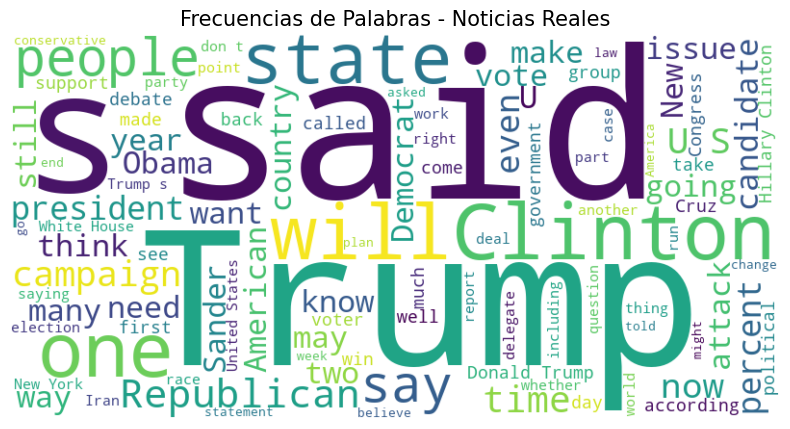

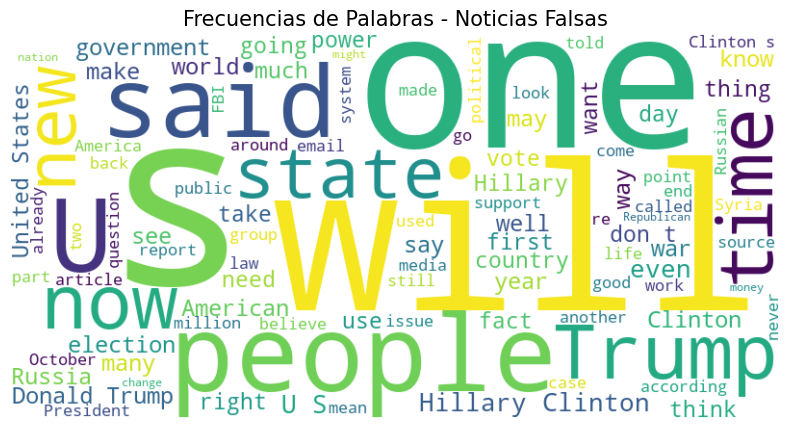

In [6]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import gdown
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
import pickle
from sklearn.preprocessing import StandardScaler
#FernandoSanchez Cargar la base de datos
df = pd.read_csv('news1.csv')

#FernandoSanchez Filtrar entradas no deseadas en la columna 'label'
df = df[df['label'].isin(['REAL', 'FAKE'])]

#FernandoSanchez Eliminar filas con valores NaN en la columna 'text'
df = df.dropna(subset=['text'])

#FernandoSanchez Realizar un conteo por clase (columna label)
class_counts = df['label'].value_counts()
print(class_counts)

#FernandoSanchez Dividir el conjunto de datos en entrenamiento y test (33%)
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

#FernandoSanchez Exploración de frecuencias de palabras
def plot_word_frequencies(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

#FernandoSanchez Generar frecuencias de palabras para el conjunto de entrenamiento
real_text = train_df[train_df['label'] == 'REAL']['text'].astype(str)
fake_text = train_df[train_df['label'] == 'FAKE']['text'].astype(str)

#FernandoSanchez Plotear frecuencias de palabras
plot_word_frequencies(real_text, 'Frecuencias de Palabras - Noticias Reales')
plot_word_frequencies(fake_text, 'Frecuencias de Palabras - Noticias Falsas')

"""Las palabras frecuentes en noticias reales son: trump, clinton, state, republican, us, said, country, democrat, etc.
Las palabras frecuentes en noticias fake son: said, trump, one, state, will, people, etc.
Las palabras con mayor frecuencia salen más grandes"""

2. Para nuestro análisis usaremos un Word Embedding ya entrenado, en particular
utilizaremos word2Vec entrenado con corpus Google News con 3 millones de
palabras, cada una representada con 300 dimensiones. Para esto, carga Word
Embedding de Google como se muestra a continuación
url = 'https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK'
# Nombre del archivo descargado
nombre_archivo = 'archivo.bin'
# Descargar el archivo desde Google Drive
gdown.download(url, nombre_archivo, quiet=False)
# Cargar el archivo con KeyedVectors
word2vec_model_google =
KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)
Tokeniza las palabras del conjunto de entrenamiento con un máximo de 80.000
palabras para el vocabulario, y realiza padding para cada secuencia con largo
máximo de 80. Finalmente, crea la matriz de embedding usando el Word2Vec pre
entrenado.


In [8]:
#FernandoSanchez Cargar el modelo Word2Vec preentrenado
url = 'https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK'
nombre_archivo = 'GoogleNews-vectors-negative300.bin'
gdown.download(url, nombre_archivo, quiet=False)
#FernandoSanchez Cargar el archivo con KeyedVectors
word2vec_model_google = KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)

#FernandoSanchez Tokenizar el conjunto de entrenamiento
#FernandoSanchez Utilizaremos el mismo train_df del paso anterior
train_texts = train_df['text'].astype(str).tolist()
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
word_index = tokenizer.word_index

#FernandoSanchez Realizar el padding para cada secuencia
max_length = 80
data = pad_sequences(sequences, maxlen=max_length)

#FernandoSanchez Crear la matriz de embedding
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i >= 80000:
        continue
    embedding_vector = word2vec_model_google.get_vector(word) if word in word2vec_model_google else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#FernandoSanchez Guardar tokenizer y embedding_matrix para su uso posterior
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
np.save('embedding_matrix.npy', embedding_matrix)

print("Tokenización y creación de la matriz de embedding completadas.")


Tokenización y creación de la matriz de embedding completadas.


3. Implementa un modelo de red neuronal recurrente LSTM, con un mínimo de tres
capas, empleando regularización Dropout. (Considera la capa de Embedding con los
pesos pre-entrenados). El modelo debe lograr un accuracy superior al 80% y la
cantidad de épocas no debe superar las 20. Muestra las métricas apropiadas para
medir el rendimiento del modelo, incluyendo la curva ROC.


In [15]:
#FernandoSanchez Cargar datos preprocesados y matrices necesarias
embedding_matrix = np.load('embedding_matrix.npy')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

max_length = 80  #FernandoSanchez Longitud máxima de la secuencia
embedding_dim = 300  #FernandoSanchez Dimensión de los embeddings

#FernandoSanchez Preparar datos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)
train_texts = train_df['text'].astype(str).tolist()
test_texts = test_df['text'].astype(str).tolist()

#FernandoSanchez Tokenización y padding de secuencias
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(train_sequences, maxlen=max_length)
X_test = pad_sequences(test_sequences, maxlen=max_length)

#FernandoSanchez Definir etiquetas y convertirlas a formato binario (REAL=1, FAKE=0)
y_train = (train_df['label'] == 'REAL').astype(int).values
y_test = (test_df['label'] == 'REAL').astype(int).values

#FernandoSanchez Definir el modelo LSTM
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

#FernandoSanchez Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#FernandoSanchez Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

#FernandoSanchez Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy:.4f}')

#FernandoSanchez Guardar el modelo
model.save('news_classifier_lstm.keras')


Epoch 1/20


C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.6561 - loss: 0.6143 - val_accuracy: 0.7875 - val_loss: 0.4648
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8106 - loss: 0.4305 - val_accuracy: 0.8231 - val_loss: 0.4099
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8316 - loss: 0.3772 - val_accuracy: 0.8221 - val_loss: 0.3875
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8692 - loss: 0.3195 - val_accuracy: 0.8529 - val_loss: 0.3329
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8949 - loss: 0.2688 - val_accuracy: 0.8428 - val_loss: 0.3630
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.8968 - loss: 0.2700 - val_accuracy: 0.8639 - val_loss: 0.3184
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9205 - loss: 0.2007 - val_accuracy: 0.8750 - val_loss: 0.3294
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9474 - loss: 0.1449 - val_accuracy: 0.8784 - val_loss: 0

4. Realiza predicciones para el conjunto de noticias del archivo “news_pred.csv”, que
contiene siete noticias. Analiza una noticia en la que el modelo se equivoque; si no la
hay, una en la que acierte el modelo. Comenta tu resultado.


In [16]:
#FernandoSanchez Cargar el modelo entrenado
model = load_model('news_classifier_lstm.keras')

#FernandoSanchez Cargar el tokenizer y la matriz de embedding
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

embedding_matrix = np.load('embedding_matrix.npy')

#FernandoSanchez Cargar las noticias para predicción
news_pred = pd.read_csv('news_pred.csv')

#FernandoSanchez Tokenizar y convertir las noticias a secuencias
pred_texts = news_pred['text'].astype(str).tolist()
sequences_pred = tokenizer.texts_to_sequences(pred_texts)
X_pred = pad_sequences(sequences_pred, maxlen=80)

#FernandoSanchez Realizar predicciones
predictions = model.predict(X_pred)
predicted_labels = ['REAL' if pred > 0.5 else 'FAKE' for pred in predictions]

#FernandoSanchez Agregar las predicciones al DataFrame original
news_pred['predicted_label'] = predicted_labels

#FernandoSanchez Mostrar el resultado
print(news_pred[['text', 'predicted_label']])

"""El modelo acerto en todas las noticias"""


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
                                                text predicted_label
0  Gunmen stormed the offices of the satirical ne...            REAL
1  World leaders' personal chefs sample Indian ma...            FAKE
2  Tweet Widget by Black Power Front \nWith stude...            FAKE
3  Gay man finds it in himself to tolerate religi...            FAKE
4  Get short URL 0 27 0 0 On Tuesday, National In...            FAKE
5  More Floods, More Drought Inevitable. How Bad ...            REAL
6  President Obama’s executive action sparing mil...            REAL


5. Carga la base de datos de artículos publicados por Mashable llamada
“OnlineNewsPopularity.csv”, quita los espacios en blanco que existen en los
nombres de las características y elimina columnas que no aporten información a
modelos de predicción de la cantidad de veces que el artículo se compartirá. Revisa
la existencia o no de valores ausentes y decide qué hacer con ellos en caso que
corresponda. Finalmente, calcula los principales indicadores estadísticos para las
variables numéricas y comenta.


In [24]:
#FernandoSanchez Cargar el dataset
df = pd.read_csv('OnlineNewsPopularity.csv')

#FernandoSanchez Eliminar espacios en blanco en los nombres de las características
df.columns = df.columns.str.strip()

#FernandoSanchez Revisar la existencia de valores ausentes
missing_values = df.isnull().sum()
print("Valores nulos por columna:\n", missing_values)

#FernandoSanchez Eliminar columnas irrelevantes para modelos de predicción de shares
columns_to_drop = ['url']
df = df.drop(columns_to_drop, axis=1)

#FernandoSanchez Calcular indicadores estadísticos para las variables numéricas
numeric_stats = df.describe()
print("Principales indicadores estadísticos:\n", numeric_stats)


#FernandoSanchez Mostrar las primeras filas del dataframe limpio
print(df.head())

"""timedelta: El intervalo de tiempo entre la fecha de publicación y la fecha en que se recopilaron los datos varía ampliamente, 
con un promedio de aproximadamente 355 días y una desviación estándar de 214 días. Esto indica que los artículos del dataset abarcan un período considerable de tiempo.

n_tokens_title y n_tokens_content: El número promedio de tokens en el título es aproximadamente 10.4, 
mientras que para el contenido es alrededor de 546.5 tokens. La variabilidad en el contenido es significativa,
 como lo muestra la desviación estándar de 471.1 para n_tokens_content, indicando que algunos artículos son considerablemente más largos que otros.

n_unique_tokens y n_non_stop_unique_tokens: Estos indican la proporción de tokens únicos en comparación con el total de tokens y tokens no detenidos respectivamente. 
Ambos tienen una media alrededor de 0.55, lo que sugiere que, en promedio, los artículos tienen una diversidad moderada en términos de sus palabras únicas.

num_hrefs, num_self_hrefs, num_imgs y num_videos: Estos atributos describen el número de enlaces externos, enlaces internos, imágenes y videos en los artículos.
 La media de num_hrefs es aproximadamente 10.9, lo que sugiere que la mayoría de los artículos tienen un número moderado de enlaces externos.

global_subjectivity y global_sentiment_polarity: Estos atributos están relacionados con la subjetividad y la polaridad del sentimiento del contenido de los artículos. 
La media de global_subjectivity es de aproximadamente 0.28, lo que indica que en promedio los artículos tienen cierto grado de subjetividad. 
La media de global_sentiment_polarity es de aproximadamente 0.07, lo que sugiere que, en promedio, los artículos tienden a tener un sentimiento ligeramente positivo.

shares: Este es el atributo objetivo que indica la cantidad de veces que se compartió un artículo. 
Los estadísticos muestran que hay una gran variabilidad en el número de veces que se comparten los artículos, 
con un rango desde 1 hasta 843,300 y una media de aproximadamente 3395. Esto sugiere que algunos artículos tienen una popularidad excepcionalmente alta, 
mientras que la mayoría tiene un número relativamente bajo de shares."""

Valores nulos por columna:
 url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64
Principales indicadores estadísticos:
           timedelta  n_tokens_title  n_tokens_content  n_unique_tokens   
count  39644.000000    39644.000000      39644.000000     39644.000000  \
mean     354.530471       10.398749        546.514731         0.548216   
std      214.163767        2.114037        471.107508         3.520708   
min        8.000000        2.000000          0.000000         0.000000   
25%      164.000000        9.000000        246.000000         0.470870   
50%      339.000000       10.000000        409.000000         0.539226   
75%      542.000

'timedelta: El intervalo de tiempo entre la fecha de publicación y la fecha en que se recopilaron los datos varía ampliamente, \ncon un promedio de aproximadamente 355 días y una desviación estándar de 214 días. Esto indica que los artículos del dataset abarcan un período considerable de tiempo.\n\nn_tokens_title y n_tokens_content: El número promedio de tokens en el título es aproximadamente 10.4, \nmientras que para el contenido es alrededor de 546.5 tokens. La variabilidad en el contenido es significativa,\n como lo muestra la desviación estándar de 471.1 para n_tokens_content, indicando que algunos artículos son considerablemente más largos que otros.\n\nn_unique_tokens y n_non_stop_unique_tokens: Estos indican la proporción de tokens únicos en comparación con el total de tokens y tokens no detenidos respectivamente. \nAmbos tienen una media alrededor de 0.55, lo que sugiere que, en promedio, los artículos tienen una diversidad moderada en términos de sus palabras únicas.\n\nnum_hr

6. Realice una búsqueda de outliers para la variable objetivo shares y elimina estos
valores. Muestra gráficamente la distribución de la variable con outliers y sin outliers.
Calcula y muestra gráficamente las correlaciones entre las variables numéricas y
lista aquellas cuyas correlaciones son mayores a 0.7 en términos absolutos; luego
elimina una variable de cada par de ellas con correlaciones altas. Debes mostrar
gráficamente la situación antes de la eliminación de variables con alta correlación y
después de haber realizado la eliminación.


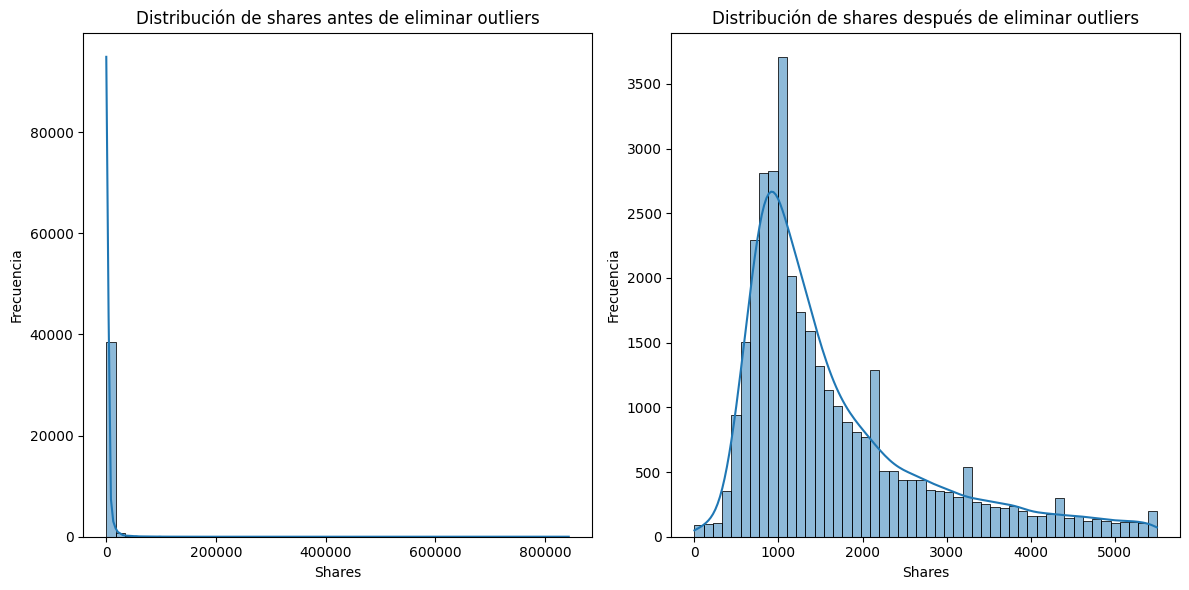

Correlaciones antes de eliminar variables con alta correlación:
n_unique_tokens - n_non_stop_words: 0.9995717371218911
n_unique_tokens - n_non_stop_unique_tokens: 0.9998515160178297
n_non_stop_words - n_non_stop_unique_tokens: 0.9995323282505376
data_channel_is_bus - LDA_00: 0.7746505220376488
data_channel_is_tech - LDA_04: 0.7497371213874283
data_channel_is_world - LDA_02: 0.8366182756593871
kw_min_min - kw_max_max: -0.8572262246429739
kw_max_min - kw_avg_min: 0.9405286635291802
kw_max_avg - kw_avg_avg: 0.8118643951010985
self_reference_min_shares - self_reference_avg_sharess: 0.8189071252672916
self_reference_max_shares - self_reference_avg_sharess: 0.8534802286627771
weekday_is_sunday - is_weekend: 0.7016478068288454
global_sentiment_polarity - rate_positive_words: 0.7278273896609666
global_rate_negative_words - rate_negative_words: 0.7795556150649772
avg_positive_polarity - max_positive_polarity: 0.7035581335809635
avg_negative_polarity - min_negative_polarity: 0.7488961778499011
t

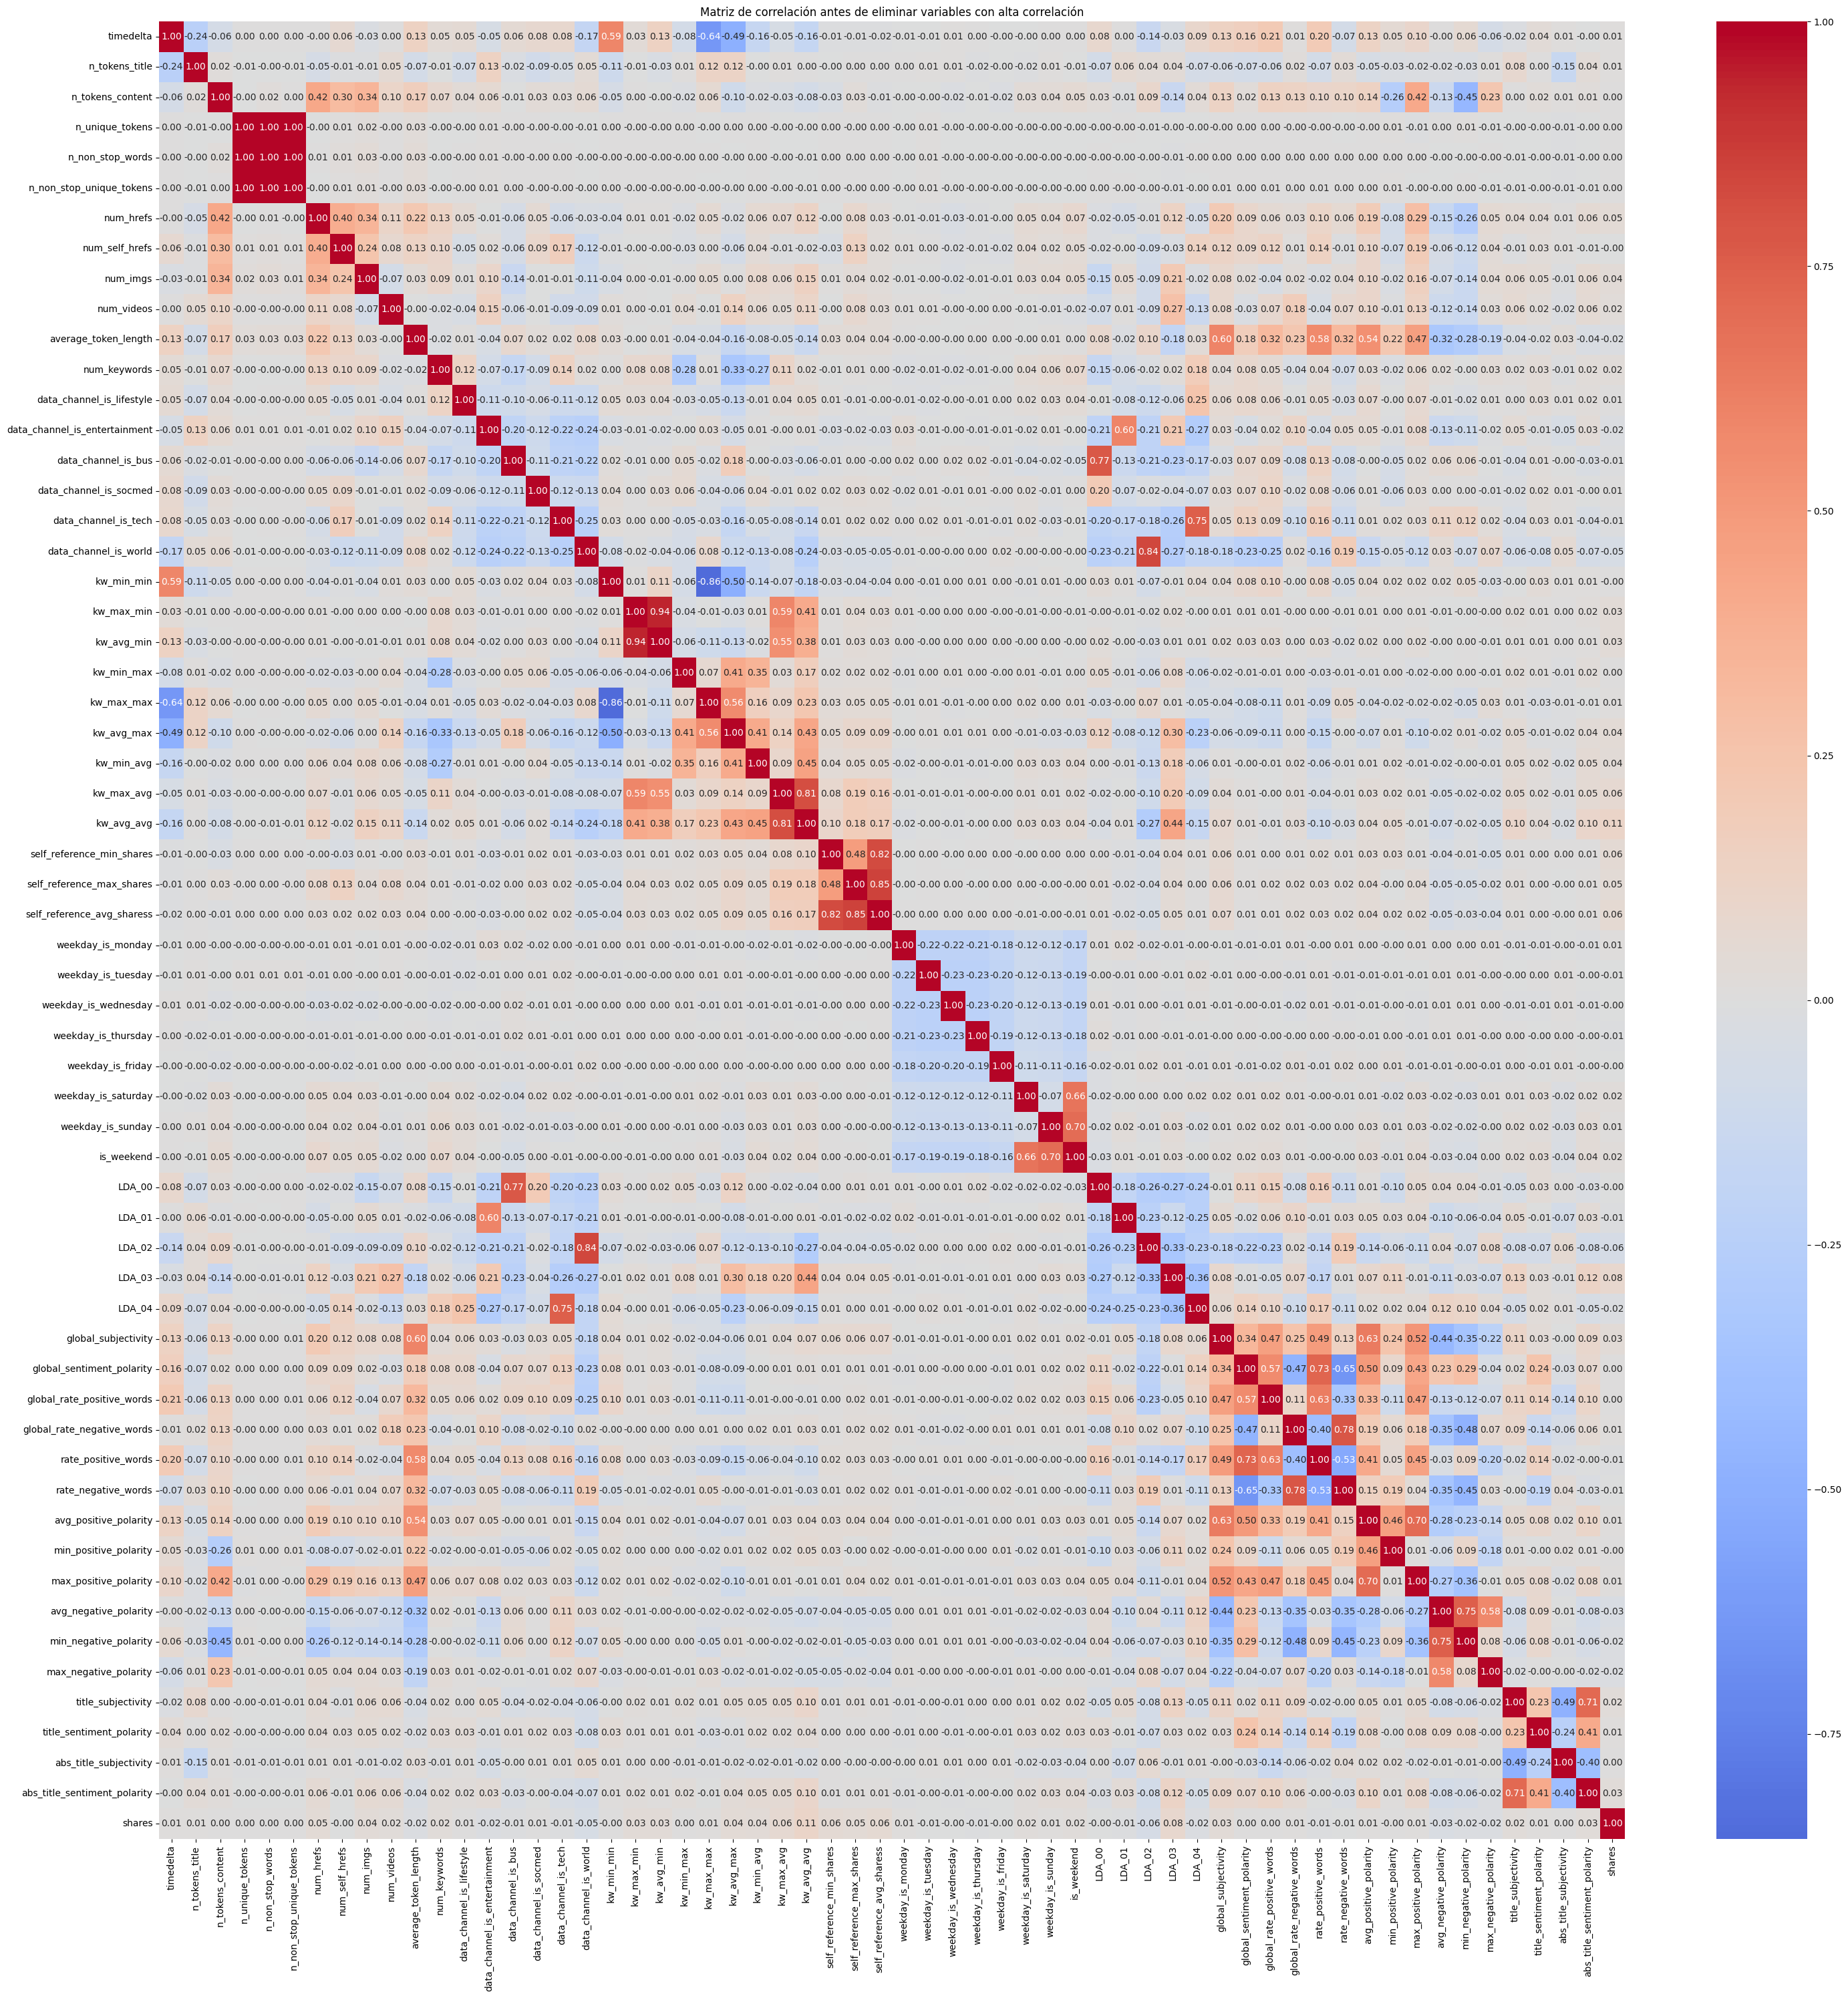

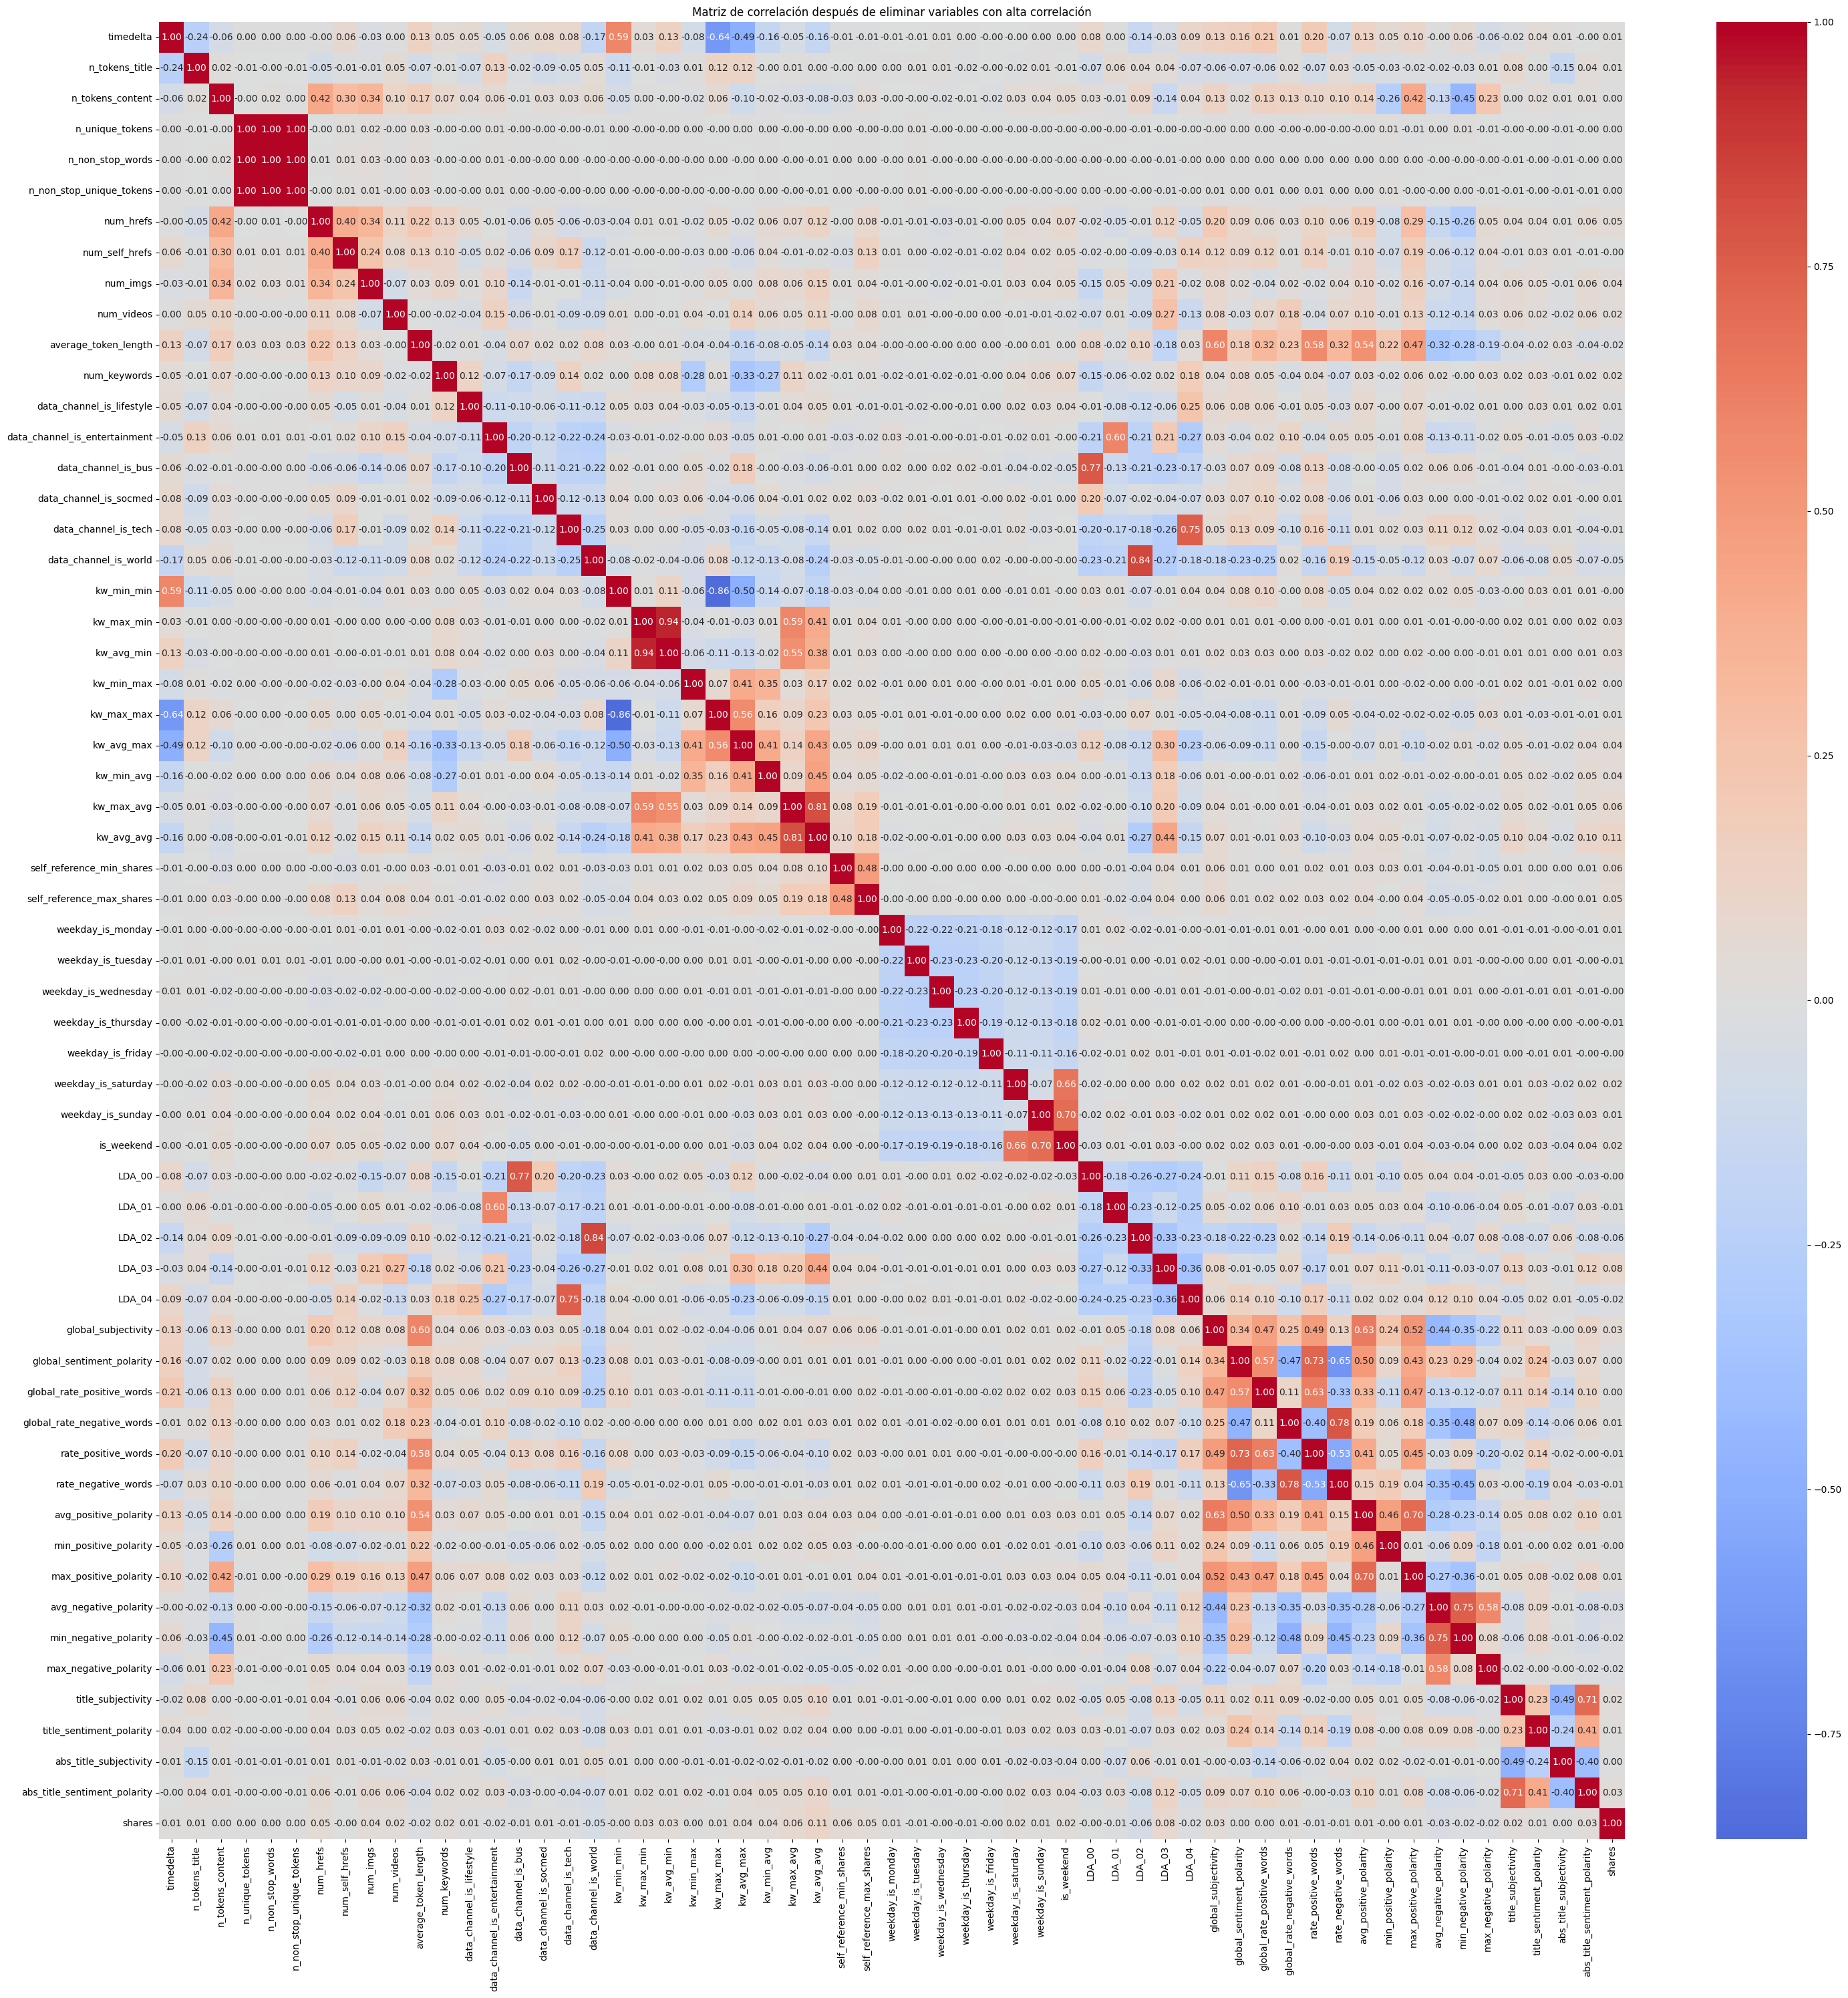

In [29]:
#FernandoSanchez Visualización de la distribución de 'shares' antes y después de eliminar outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['shares'], bins=50, kde=True)
plt.title('Distribución de shares antes de eliminar outliers')
plt.xlabel('Shares')
plt.ylabel('Frecuencia')

#FernandoSanchez Filtrar outliers
Q1 = df['shares'].quantile(0.25)
Q3 = df['shares'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df[(df['shares'] >= lower_bound) & (df['shares'] <= upper_bound)]

plt.subplot(1, 2, 2)
sns.histplot(df_no_outliers['shares'], bins=50, kde=True)
plt.title('Distribución de shares después de eliminar outliers')
plt.xlabel('Shares')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.savefig('shares_distribution.png')
plt.show()

#FernandoSanchez Calcular matriz de correlación antes de eliminar variables con alta correlación
correlation_matrix_before = df.corr()

#FernandoSanchez Encontrar pares de variables con correlación mayor a 0.7 en valor absoluto
high_corr_pairs_before = []
numeric_columns = df.select_dtypes(include=np.number).columns

for i in range(len(numeric_columns)):
    for j in range(i + 1, len(numeric_columns)):
        corr = correlation_matrix_before.loc[numeric_columns[i], numeric_columns[j]]
        if abs(corr) > 0.7:
            high_corr_pairs_before.append((numeric_columns[i], numeric_columns[j], corr))

#FernandoSanchez Eliminar una variable de cada par de alta correlación
df_no_high_corr = df.drop(columns=['self_reference_avg_sharess'])

#FernandoSanchez Calcular matriz de correlación después de eliminar variables con alta correlación
correlation_matrix_after = df_no_high_corr.corr()

#FernandoSanchez Encontrar pares de variables con correlación mayor a 0.7 en valor absoluto después de la eliminación
high_corr_pairs_after = []
numeric_columns_after = df_no_high_corr.select_dtypes(include=np.number).columns

for i in range(len(numeric_columns_after)):
    for j in range(i + 1, len(numeric_columns_after)):
        corr = correlation_matrix_after.loc[numeric_columns_after[i], numeric_columns_after[j]]
        if abs(corr) > 0.7:
            high_corr_pairs_after.append((numeric_columns_after[i], numeric_columns_after[j], corr))


#FernandoSanchez Visualización de la matriz de correlación antes de eliminar variables con alta correlación
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix_before, cmap='coolwarm', annot=True, fmt=".2f", center=0)
plt.title('Matriz de correlación antes de eliminar variables con alta correlación')
plt.tight_layout()
plt.savefig('correlation_matrix_before.png')
plt.show()

#FernandoSanchez Visualización de la matriz de correlación después de eliminar variables con alta correlación
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix_after, cmap='coolwarm', annot=True, fmt=".2f", center=0)
plt.title('Matriz de correlación después de eliminar variables con alta correlación')
plt.tight_layout()
plt.savefig('correlation_matrix_after.png')
plt.show()


7. Escoge cuatro variables numéricas y analiza su distribución. Luego normaliza todas
las variables numéricas y divide los datos en entrenamiento y test (33%).


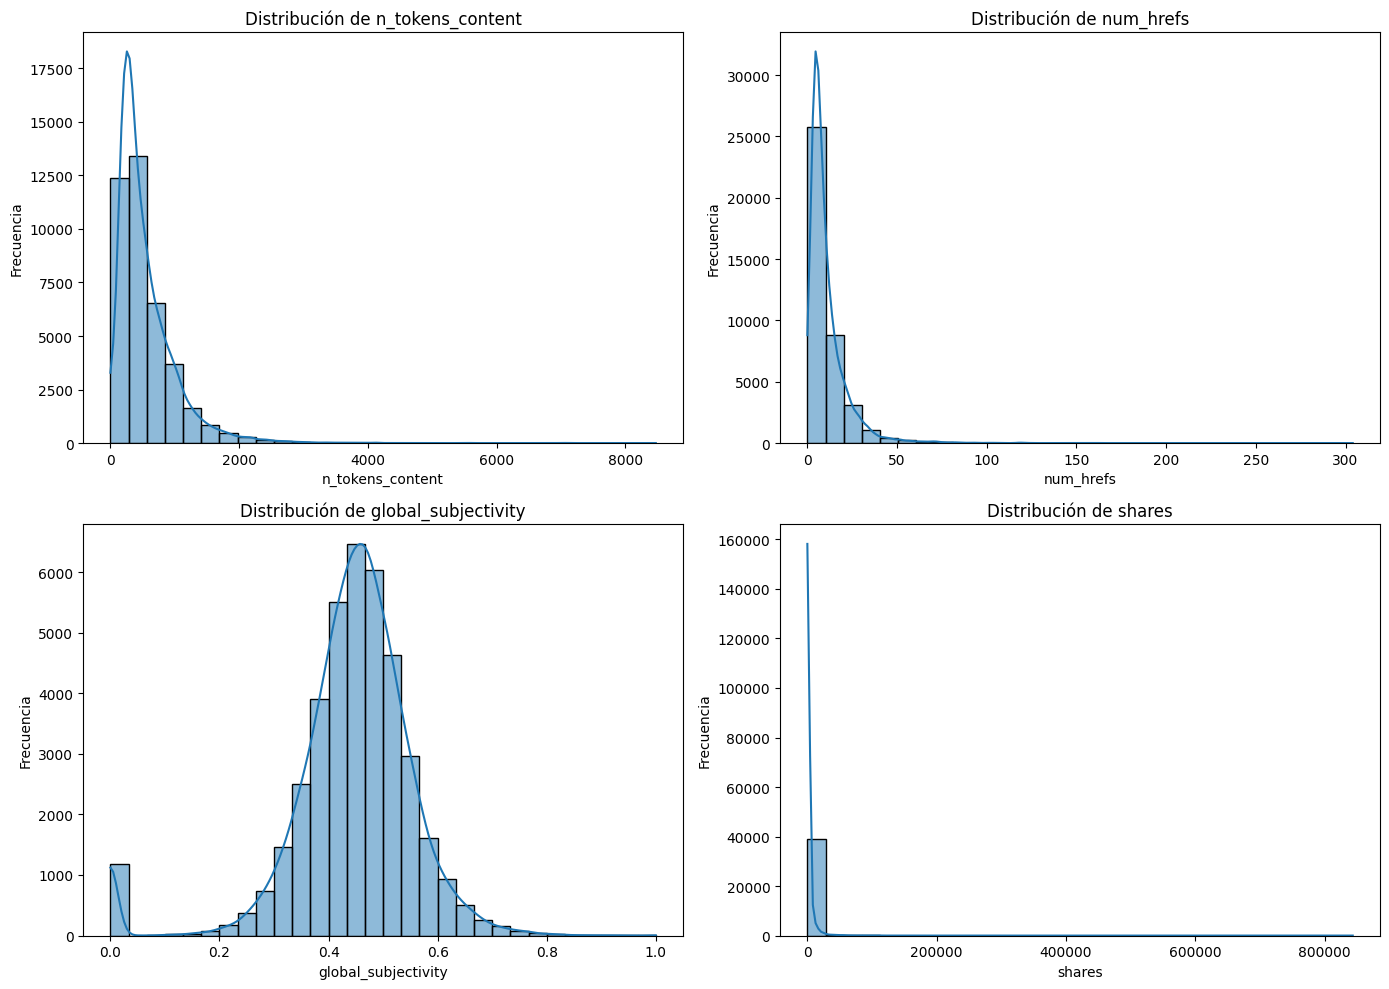

DataFrame con variables normalizadas:
   n_tokens_content  num_hrefs  global_subjectivity    shares    LDA_00   
0         -0.695210  -0.607463             0.670593 -0.241028  0.500331  \
1         -0.618794  -0.695709            -0.875228 -0.230879  0.799756   
2         -0.712192  -0.695709             2.218418 -0.163018  0.217792   
3         -0.032933  -0.166229            -0.115874 -0.188821  0.028573   
4          1.115439   0.716237             0.601046 -0.248596  0.028633   

     LDA_01    LDA_02    LDA_03    LDA_04  abs_title_sentiment_polarity  ...   
0  0.378279  0.040005  0.041263  0.040123                      0.187500  ...  \
1  0.050047  0.050096  0.050101  0.050001                      0.000000  ...   
2  0.033334  0.033351  0.033334  0.682188                      0.000000  ...   
3  0.419300  0.494651  0.028905  0.028572                      0.000000  ...   
4  0.028794  0.028575  0.028572  0.885427                      0.136364  ...   

   timedelta  title_sentiment_

In [32]:
#FernandoSanchez Seleccionar las cuatro variables numéricas
selected_features = ['n_tokens_content', 'num_hrefs', 'global_subjectivity', 'shares']

#FernandoSanchez Visualizar la distribución de las variables seleccionadas
plt.figure(figsize=(14, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

#FernandoSanchez Extraer las variables numéricas
numeric_features = df[selected_features]

#FernandoSanchez Normalizar las variables numéricas
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

#FernandoSanchez Crear un nuevo DataFrame con las variables normalizadas
df_normalized = pd.DataFrame(scaled_features, columns=selected_features)

#FernandoSanchez Añadir las columnas no numéricas y de objetivo al DataFrame normalizado
df_normalized[df.columns.difference(selected_features)] = df[df.columns.difference(selected_features)]

#FernandoSanchez Mostrar las primeras filas del DataFrame normalizado
print("DataFrame con variables normalizadas:")
print(df_normalized.head())

#FernandoSanchez Definir las variables independientes (X) y la variable dependiente (y)
X = df_normalized.drop('shares', axis=1)
y = df_normalized['shares']

#FernandoSanchez Dividir los datos en entrenamiento y test (33% para test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#FernandoSanchez Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
print(f"Dimensiones de los conjuntos de entrenamiento: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensiones de los conjuntos de prueba: X_test: {X_test.shape}, y_test: {y_test.shape}")


8. Entrena un modelo de Random Forest usando búsqueda de grilla. La búsqueda debe
considerar:
● para n_estimators, valores entre 100 y 300 para 10 valores
● para max_depth, valores entres 2 y 15 para 10 valores
● para max_features, buscar para ‘sqrt’ y ‘log2’.
En la búsqueda de grilla considera cinco fold. Muestra los mejores hiper parámetros
encontrados por la búsqueda de grilla. Calcula dos métricas sobre el conjunto de
test, para evaluar el modelo.


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#FernandoSanchez Definir el modelo de Random Forest
rf = RandomForestRegressor(random_state=42)

#FernandoSanchez Definir los parámetros para la búsqueda de grilla
param_grid = {
    'n_estimators': list(range(100, 301, 20)),
    'max_depth': list(range(2, 16, 2)),
    'max_features': ['sqrt', 'log2']
}

#FernandoSanchez Configurar la búsqueda de grilla con validación cruzada de 5 fold
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#FernandoSanchez Entrenar la búsqueda de grilla en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

#FernandoSanchez Obtener los mejores hiperparámetros encontrados por la búsqueda de grilla
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados por la búsqueda de grilla:")
print(best_params)

#FernandoSanchez Obtener el mejor modelo entrenado
best_rf = grid_search.best_estimator_

#FernandoSanchez Predecir sobre el conjunto de prueba
y_pred = best_rf.predict(X_test)

#FernandoSanchez Calcular métricas sobre el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMétricas sobre el conjunto de prueba:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

"""un MSE de 1.20 indica que las predicciones del modelo tienen un error cuadrático medio de aproximadamente 1.20 unidades cuadradas en la escala original de las shares.
Un R^2 de 0.02 sugiere que el modelo explica muy poco de la variabilidad de los datos de prueba, lo cual es bastante bajo."""

Mejores hiperparámetros encontrados por la búsqueda de grilla:
{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}

Métricas sobre el conjunto de prueba:
Mean Squared Error (MSE): 1.20
R^2 Score: 0.02


9. Entrena un modelo de red neuronal Fully Connected con al menos dos capas ocultas
y aplicando regularización Dropout. Utiliza en cada capa una cantidad de neuronas
mayor a 300. Calcula las mismas métricas usadas en el modelo anterior, sobre el
conjunto de test, para evaluar el modelo.



In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

#FernandoSanchez Definir el modelo de red neuronal
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(384, activation='relu'),
    Dropout(0.5),
    Dense(1)  #FernandoSanchez Capa de salida para la regresión
])

#FernandoSanchez Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

#FernandoSanchez Resumen del modelo
model.summary()

#FernandoSanchez Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

#FernandoSanchez Evaluar el modelo en el conjunto de prueba
y_pred_nn = model.predict(X_test).flatten()

#FernandoSanchez Calcular métricas sobre el conjunto de prueba
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\nMétricas sobre el conjunto de prueba para la red neuronal:")
print(f"Mean Squared Error (MSE): {mse_nn:.2f}")
print(f"R^2 Score: {r2_nn:.2f}")



C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,097 (891.00 KB)

 Trainable params: 228,097 (891.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 544678272.0000 - mse: 544678272.0000 - val_loss: 4370.6035 - val_mse: 4370.6035
Epoch 2/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 572351.8125 - mse: 572351.8125 - val_loss: 23.4658 - val_mse: 23.4658
Epoch 3/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 109765.1328 - mse: 109765.1328 - val_loss: 0.6949 - val_mse: 0.6949
Epoch 4/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 42847.7500 - mse: 42847.7500 - val_loss: 0.5851 - val_mse: 0.5851
Epoch 5/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 28042.8789 - mse: 28042.8867 - val_loss: 0.5851 - val_mse: 0.5851
Epoch 6/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 24516.6680 - mse: 24516.6680 - val_loss: 0.5851 - val_mse: 0.5851
Epoch 7/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8621.1328 - mse: 8621.1328 - val_loss: 0.5851 - val_mse: 0.5851
Epoch 8/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 25071.7793 - mse: 25071.7793 - val_loss:

10. Implementa y entrena un modelo Extreme Gradient Boosting, usando búsqueda de
grilla con 5 fold. Para ello considera:
● n_estimators: [100, 120, 150, 200, 300]
● learning_rate: [0.008, 0.07, 0.009, 0.01, 0.02]
● subsample: np.linspace(0.05, 1, 5)
● scale_pos_weight: np.linspace(0.8, 0.9, 2)
Muestra los mejores hiper parámetros encontrados, calcula y muestra gráficamente la
importancia de las características para la predicción en el modelo. Calcula las mismas
métricas usadas en el modelo anterior, sobre el conjunto de test, para evaluar el modelo.


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Mejores hiperparámetros encontrados: {'learning_rate': 0.008, 'n_estimators': 120, 'scale_pos_weight': 0.8, 'subsample': 0.05}
Mean Squared Error (MSE): 1.2064416420153519
R^2 Score: 0.013148796427612242


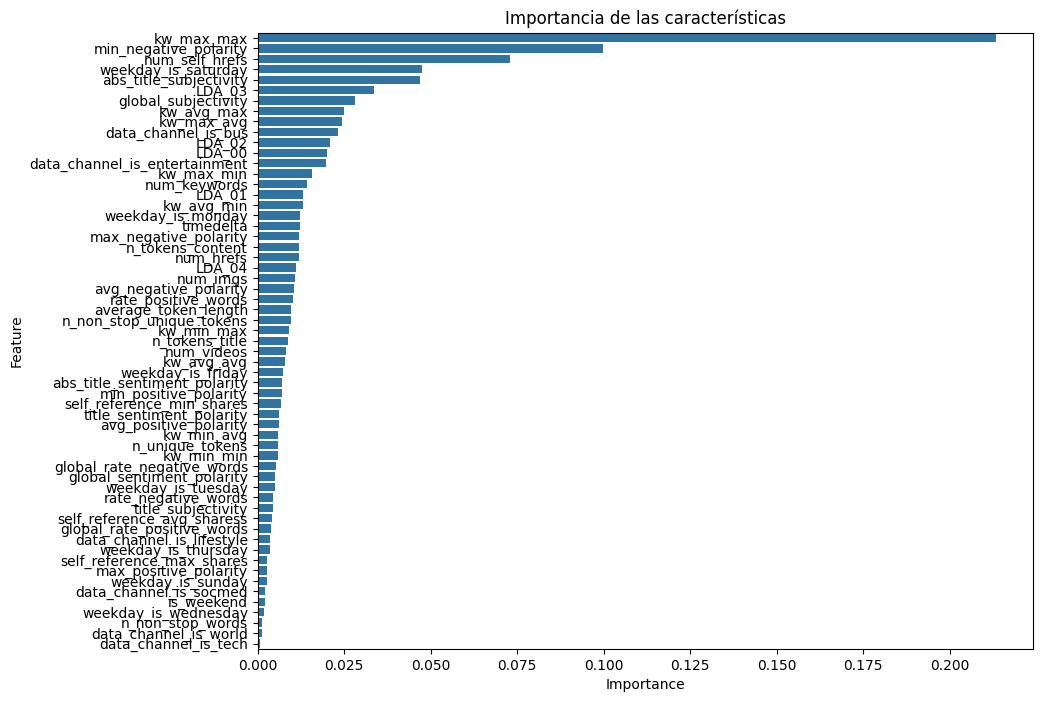

In [36]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#FernandoSanchez Parámetros para la búsqueda de grilla
param_grid = {
    'n_estimators': [100, 120, 150, 200, 300],
    'learning_rate': [0.008, 0.07, 0.009, 0.01, 0.02],
    'subsample': np.linspace(0.05, 1, 5),
    'scale_pos_weight': np.linspace(0.8, 0.9, 2)
}

#FernandoSanchez Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

#FernandoSanchez Configuración del GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

#FernandoSanchez Ajustar el modelo con la búsqueda de grilla
grid_search.fit(X_train, y_train)

#FernandoSanchez Mostrar los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros encontrados: {best_params}")

#FernandoSanchez Hacer predicciones en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#FernandoSanchez Calcular MSE y R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

#FernandoSanchez Obtener la importancia de las características
feature_importances = best_model.feature_importances_

#FernandoSanchez Crear un DataFrame con las importancias
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

#FernandoSanchez Ordenar por importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

#FernandoSanchez Graficar la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las características')
plt.show()


11. Construye un modelo de Bagging usando al menos tres modelos heterogéneos. Para
ello utiliza la siguiente función (utilizando el archivo entregado):
import util_bagging as ubagging
ubagging.bagging_het
Calcula las mismas métricas usadas en el modelo anterior, sobre el conjunto de test,
para evaluar el modelo.
Muestra en un DataFrame los resultados de todos los modelos y concluye.

In [38]:
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import util_bagging as ubagging

# Creación de los modelos heterogéneos
estimators = [DecisionTreeRegressor(), LinearRegression(), SVR()]

# Número de estimadores
T = 10

# Entrenamiento del modelo Bagging
trained_models, yhat_test, yhat_out, idx_oob = ubagging.bagging_het(X_train, y_train, T, estimators, X_test)

# Evaluación del modelo
y_pred = yhat_out
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')

# Resultados de los diferentes modelos
results = {
    'Modelo': ['Random Forest', 'Neural Network', 'XGBoost', 'Bagging'],
    'MSE': [1.20, 1.22, 1.21, mse],
    'R^2 Score': [0.02, -0.00, 0.0131, r2]
}

# Crear el DataFrame
results_df = pd.DataFrame(results)

# Mostrar el DataFrame
print(results_df)

"""Mejor Modelo: El modelo de Random Forest mostró el mejor rendimiento entre los modelos probados, con el menor MSE y un R² Score positivo.
Modelos Adecuados: Tanto Random Forest como XGBoost tienen un rendimiento relativamente bueno. Sin embargo, la diferencia entre ellos es mínima.
Modelos Subóptimos: La red neuronal (Neural Network) y el modelo de Bagging tienen un rendimiento inferior, especialmente el modelo de Bagging, que tiene el peor rendimiento entre todos los modelos probados."""

Mean Squared Error (MSE): 1.654440845004872
R^2 Score: -0.353307845379893
           Modelo       MSE  R^2 Score
0   Random Forest  1.200000   0.020000
1  Neural Network  1.220000  -0.000000
2         XGBoost  1.210000   0.013100
3         Bagging  1.654441  -0.353308
